# Real-NVP

Real-NVP implementation in less than 100 lines of [JAX](https://github.com/google/jax)

Author: Eric Jang

In [1]:
from typing import Any
import tensorflow_datasets as tfds
from pathlib import Path
from datasets.confounded_mnist import confoudned_mnist
from jax.lib import xla_bridge
import tensorflow as tf
from tqdm import tqdm
from staxplus import train
from jax import value_and_grad
from typing import Tuple, Dict
import optax
from staxplus.real_nvp import nvp_1d, glow
from staxplus.types import is_shape
from staxplus import StaxLayer, Model, Params, KeyArray, Array, ArrayTree, GradientTransformation, OptState, ShapeTree
from jax import jit, grad
from jax.example_libraries.stax import Dense, Relu, serial, Conv
from jax.example_libraries import optimizers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from numpyro.distributions import Normal, Independent
from jax import random
import jax.numpy as jnp
print(xla_bridge.get_backend().platform)
tf.config.experimental.set_visible_devices([], 'GPU')


gpu


## Data

$p(x)$

(-2.0, 2.0)

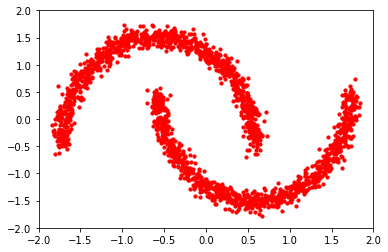

In [2]:
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

## Base Distribution

<AxesSubplot:ylabel='Count'>

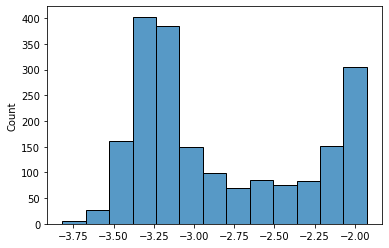

In [3]:
prior = Independent(Normal(jnp.zeros(2), jnp.ones(2)), 1)
sns.histplot(data=prior.log_prob(X))

## Real-NVP

Affine coupling layer

$x_2=x_1$

$y_2=x_1*e^{s(x_1)}+t(x_1)$


$\log p(x) = \log p(f^{-1}(x)) + |\log det J(f^{-1})(x)| $

<AxesSubplot:ylabel='Count'>

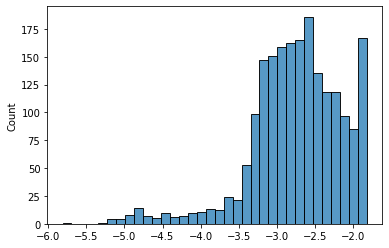

In [4]:
rng = random.PRNGKey(1)
init_fn, sample, log_prob = nvp_1d(num_coupling_layers=5, output_shape=(-1, 2))
_, params = init_fn(rng, (-1, 2))
y = sample(params, rng, 1000)
sns.histplot(log_prob(params, X))


## Train It

100%|██████████| 10000/10000 [00:08<00:00, 1207.60it/s]


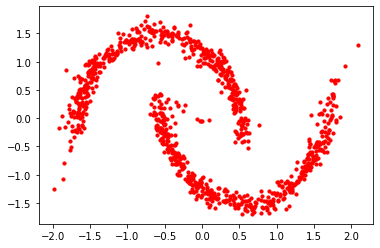

In [5]:
import numpy as np
def loss(params, batch):
  return -jnp.mean(log_prob(params, batch))


opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)


@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad(loss)(params, batch)
    return opt_update(i, g, opt_state)


iters = int(1e4)
data_generator = (X[np.random.choice(X.shape[0], 100)] for _ in range(iters))
opt_state = opt_init(params)
for i in tqdm(range(iters)):
    opt_state = step(i, opt_state, next(data_generator))

y = sample(get_params(opt_state), rng, 1000)
y.max()
plt.scatter(y[:, 0], y[:, 1], s=10, color='red')
xlim, ylim = [-3, 3], [-3, 3]
# plt.xlim(xlim)
# plt.ylim(ylim)


(): max_num_repeat=1; new_dataset_len:60000
('digit',): max_num_repeat=1; new_dataset_len:60000
('thickness',): max_num_repeat=1; new_dataset_len:60000
('digit', 'thickness'): max_num_repeat=1; new_dataset_len:60000


ZeroDivisionError: division by zero

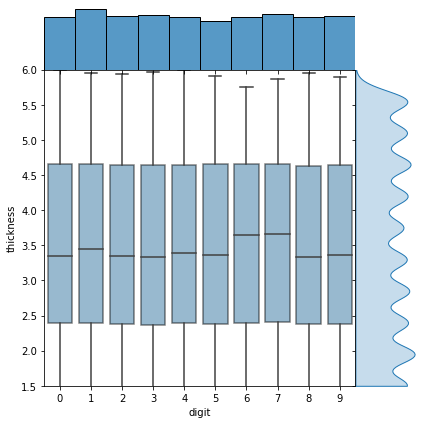

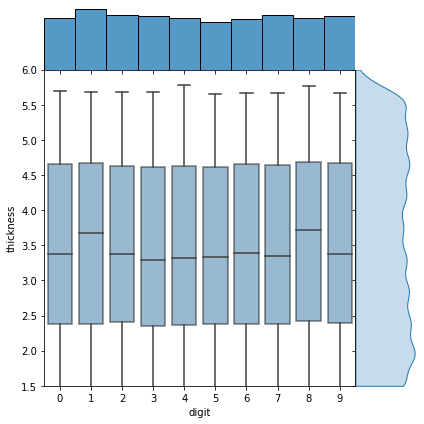

In [7]:
import jax.image


def nvp_model() -> Model:
    shape = (-1, 32, 32, 1)
    nvp_init_fn, sample, log_prob = glow(output_shape=shape)

    def init_fn(rng: KeyArray, input_shape: ShapeTree) -> Params:
        assert is_shape(input_shape)
        _, params = nvp_init_fn(rng, shape)
        return params

    def apply_fn(params: Params, rng: KeyArray, inputs: ArrayTree) -> Tuple[Array, Dict[str, Array]]:
        assert isinstance(inputs, Array)
        inputs = jax.image.resize(inputs, shape=(-1, 32, 32, 1),  method='linear')
        samples = jnp.clip(sample(params, rng, inputs.shape[0]), a_min=-1, a_max=1)
        _log_prob = log_prob(params, inputs)
        return -jnp.mean(_log_prob), {'samples': samples, 'log_prob': _log_prob}

    def update_fn(params: Params,
                  optimizer: GradientTransformation,
                  opt_state: OptState,
                  rng: KeyArray,
                  inputs: ArrayTree) -> Tuple[Params, OptState, Array, Dict[str, Array]]:
        (loss, outputs), grads = value_and_grad(apply_fn, has_aux=True)(params, rng, inputs)
        updates, opt_state = optimizer.update(updates=grads, state=opt_state, params=params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss, outputs

    return Model(init_fn, apply_fn, update_fn)


data_dir = Path('data')
job_dir = Path('/tmp/test_nvp')
dataset_name, scenario = confoudned_mnist('digit_thickness', data_dir, confound=False, scale=.1, outlier_prob=0.)
train_datasets, test_dataset, parent_dists, input_shape, _ = scenario


def to_numpy_iterator(data: tf.data.Dataset, batch_size: int, drop_remainder: bool = True) -> Any:
    return tfds.as_numpy(data.batch(batch_size,
                                    drop_remainder=drop_remainder,
                                    num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))


def select(image: Array, parents: Dict[str, Array]) -> Array:
    return image


batch_size = 512
train_data = to_numpy_iterator(train_datasets[frozenset()].map(select), batch_size=batch_size)
test_data = to_numpy_iterator(test_dataset.map(select), batch_size=batch_size, drop_remainder=True)
schedule = optax.piecewise_constant_schedule(1e-5, {12000: .1, 16000: .1})
optimizer = optax.chain(optax.adamw(learning_rate=1e-4),
                        optax.adaptive_grad_clip(clipping=0.01))

train(model=nvp_model(),
      job_dir=job_dir,
      seed=10,
      train_data=train_data,
      test_data=test_data,
      input_shape=input_shape,
      optimizer=optimizer,
      num_steps=100000,
      log_every=10,
      eval_every=500,
      save_every=1000,
      overwrite=True)
